# Custom derivative rules for JAX-transformable Python functions

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Custom_derivative_rules_for_Python_code.ipynb)

*mattjj@ Mar 19 2020, last updated Oct 14 2020*

There are two ways to define differentiation rules in JAX:

1. using `jax.custom_jvp` and `jax.custom_vjp` to define custom differentiation rules for Python functions that are already JAX-transformable; and
2. defining new `core.Primitive` instances along with all their transformation rules, for example to call into functions from other systems like solvers, simulators, or general numerical computing systems.

This notebook is about #1. To read instead about #2, see the [notebook on adding primitives](https://jax.readthedocs.io/en/latest/notebooks/How_JAX_primitives_work.html).

For an introduction to JAX's automatic differentiation API, see [The Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html). This notebook assumes some familiarity with [jax.jvp](https://jax.readthedocs.io/en/latest/jax.html#jax.jvp) and [jax.grad](https://jax.readthedocs.io/en/latest/jax.html#jax.grad), and the mathematical meaning of JVPs and VJPs.

## TL;DR

### Custom JVPs with `jax.custom_jvp`

In [1]:
import jax.numpy as jnp
from jax import custom_jvp

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

In [2]:
from jax import jvp, grad

print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278924
2.7278924
-1.2484405
-1.2484405


In [3]:
# Equivalent alternative using the defjvps convenience wrapper

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

f.defjvps(lambda x_dot, primal_out, x, y: jnp.cos(x) * x_dot * y,
          lambda y_dot, primal_out, x, y: jnp.sin(x) * y_dot)

In [4]:
print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278924
2.7278924
-1.2484405
-1.2484405


### Custom VJPs with `jax.custom_vjp`

In [5]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
# Returns primal output and residuals to be used in backward pass by f_bwd.
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res # Gets residuals computed in f_fwd
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)

In [6]:
print(grad(f)(2., 3.))

-1.2484405


## Example problems

To get an idea of what problems `jax.custom_jvp` and `jax.custom_vjp` are meant to solve, let's go over a few examples. A more thorough introduction to the `jax.custom_jvp` and `jax.custom_vjp` APIs is in [the next section](#scrollTo=Dr0aNkBslfQf).

### Numerical stability

One application of `jax.custom_jvp` is to improve the numerical stability of differentiation.

Say we want to write a function called `log1pexp`, which computes $x \mapsto \log ( 1 + e^x )$. We can write that using `jax.numpy`:

In [7]:
import jax.numpy as jnp

def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp(3.)

DeviceArray(3.0485873, dtype=float32)

Since it's written in terms of `jax.numpy`, it's JAX-transformable:

In [8]:
from jax import jit, grad, vmap

print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

3.0485873
0.95257413
[0.5        0.7310586  0.88079715]


But there's a numerical stability problem lurking here:

In [9]:
print(grad(log1pexp)(100.))

nan


That doesn't seem right! After all, the derivative of $x \mapsto \log (1 + e^x)$ is $x \mapsto \frac{e^x}{1 + e^x}$, and so for large values of $x$ we'd expect the value to be about 1.

We can get a bit more insight into what's going on by looking at the jaxpr for the gradient computation:

In [10]:
from jax import make_jaxpr

make_jaxpr(grad(log1pexp))(100.)

{ lambda  ; a.
  let b = exp a
      c = add b 1.0
      _ = log c
      d = div 1.0 c
      e = mul d b
  in (e,) }

Stepping through how the jaxpr would be evaluated, we can see that the last line would involve multiplying values that floating point math will round to 0 and $\infty$, respectively, which is never a good idea. That is, we're effectively evaluating `lambda x: (1 / (1 + jnp.exp(x))) * jnp.exp(x)` for large `x`, which effectively turns into `0. * jnp.inf`.

Instead of generating such large and small values, hoping for a cancellation that floats can't always provide, we'd rather just express the derivative function as a more numerically stable program. In particular, we can write a program that more closely evaluates the equal mathematical expression $1 - \frac{1}{1 + e^x}$, with no cancellation in sight.

This problem is interesting because even though our definition of `log1pexp` could already be JAX-differentiated (and transformed with `jit`, `vmap`, ...), we're not happy with the result of applying standard autodiff rules to the primitives comprising `log1pexp` and composing the result. Instead, we'd like to specify how the whole function `log1pexp` should be differentiated, as a unit, and thus arrange those exponentials better.

This is one application of custom derivative rules for Python functions that are already JAX transformable: specifying how a composite function should be differentiated, while still using its original Python definition for other transformations (like `jit`, `vmap`, ...).

Here's a solution using `jax.custom_jvp`:

In [11]:
from jax import custom_jvp

@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

@log1pexp.defjvp
def log1pexp_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = log1pexp(x)
  ans_dot = (1 - 1/(1 + jnp.exp(x))) * x_dot
  return ans, ans_dot

In [12]:
print(grad(log1pexp)(100.))

1.0


In [13]:
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


Here's a `defjvps` convenience wrapper to express the same thing:

In [14]:
@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp.defjvps(lambda t, ans, x: (1 - 1/(1 + jnp.exp(x))) * t)

In [15]:
print(grad(log1pexp)(100.))
print(jit(log1pexp)(3.))
print(jit(grad(log1pexp))(3.))
print(vmap(jit(grad(log1pexp)))(jnp.arange(3.)))

1.0
3.0485873
0.95257413
[0.5       0.7310586 0.8807971]


### Enforcing a differentiation convention

A related application is to enforce a differentiation convention, perhaps at a boundary.

Consider the function $f : \mathbb{R}_+ \mapsto \mathbb{R}_+$ with $f(x) = \frac{x}{1 + \sqrt{x}}$, where we take $\mathbb{R}_+ = [0, \infty)$. We might implement $f$ as a program like this:

In [16]:
def f(x):
  return x / (1 + jnp.sqrt(x))

As a mathematical function on $\mathbb{R}$ (the full real line), $f$ is not differentiable at zero (because the limit defining the derivative doesn't exist from the left). Correspondingly, autodiff produces a `nan` value:

In [17]:
print(grad(f)(0.))

nan


But mathematically if we think of $f$ as a function on $\mathbb{R}_+$ then it is differentiable at 0 [Rudin's Principles of Mathematical Analysis Definition 5.1, or Tao's Analysis I 3rd ed. Definition 10.1.1 and Example 10.1.6]. Alternatively, we might say as a convention we want to consider the directional derivative from the right. So there is a sensible value for the Python function `grad(f)` to return at `0.0`, namely `1.0`. By default, JAX's machinery for differentiation assumes all functions are defined over $\mathbb{R}$ and thus doesn't produce `1.0` here.

We can use a custom JVP rule! In particular, we can define the JVP rule in terms of the derivative function $x \mapsto \frac{\sqrt{x} + 2}{2(\sqrt{x} + 1)^2}$ on $\mathbb{R}_+$,

In [18]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  ans_dot = ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * x_dot
  return ans, ans_dot

In [19]:
print(grad(f)(0.))

1.0


Here's the convenience wrapper version:

In [20]:
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

f.defjvps(lambda t, ans, x: ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * t)

In [21]:
print(grad(f)(0.))

1.0


### Gradient clipping

While in some cases we want to express a mathematical differentiation computation, in other cases we may even want to take a step away from mathematics to adjust the computation autodiff performs. One canonical example is reverse-mode gradient clipping.

For gradient clipping, we can use `jnp.clip` together with a `jax.custom_vjp` reverse-mode-only rule:

In [22]:
from functools import partial
from jax import custom_vjp

@custom_vjp
def clip_gradient(lo, hi, x):
  return x  # identity function

def clip_gradient_fwd(lo, hi, x):
  return x, (lo, hi)  # save bounds as residuals

def clip_gradient_bwd(res, g):
  lo, hi = res
  return (None, None, jnp.clip(g, lo, hi))  # use None to indicate zero cotangents for lo and hi

clip_gradient.defvjp(clip_gradient_fwd, clip_gradient_bwd)

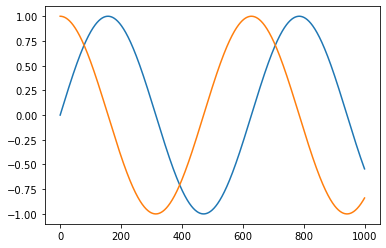

In [23]:
import matplotlib.pyplot as plt
from jax import vmap

t = jnp.linspace(0, 10, 1000)

plt.plot(jnp.sin(t))
plt.plot(vmap(grad(jnp.sin))(t))

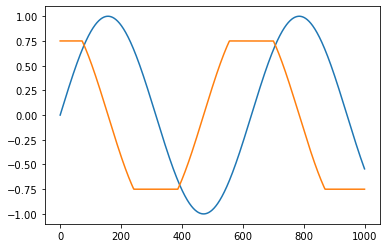

In [24]:
def clip_sin(x):
  x = clip_gradient(-0.75, 0.75, x)
  return jnp.sin(x)

plt.plot(clip_sin(t))
plt.plot(vmap(grad(clip_sin))(t))

### Python debugging

Another application that is motivated by development workflow rather than numerics is to set a `pdb` debugger trace in the backward pass of reverse-mode autodiff.

When trying to track down the source of a `nan` runtime error, or just examine carefully the cotangent (gradient) values being propagated, it can be useful to insert a debugger at a point in the backward pass that corresponds to a specific point in the primal computation. You can do that with `jax.custom_vjp`.

We'll defer an example until the next section.

### Implicit function differentiation of iterative implementations

This example gets pretty deep in the mathematical weeds!

Another application for `jax.custom_vjp` is reverse-mode differentiation of functions that are JAX-transformable (by `jit`, `vmap`, ...) but not efficiently JAX-differentiable for some reason, perhaps because they involve `lax.while_loop`. (It's not possible to produce an XLA HLO program that efficiently computes the reverse-mode derivative of an XLA HLO While loop because that would require a program with unbounded memory use, which isn't possible to express in XLA HLO, at least without side-effecting interactions through infeed/outfeed.)

For example, consider this `fixed_point` routine which computes a fixed point by iteratively applying a function in a `while_loop`:

In [25]:
from jax.lax import while_loop

def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star

This is an iterative procedure for numerically solving the equation $x = f(a, x)$ for $x$, by iterating $x_{t+1} = f(a, x_t)$ until $x_{t+1}$ is sufficiently close to $x_t$. The result $x^*$ depends on the parameters $a$, and so we can think of there being a function $a \mapsto x^*(a)$ that is implicity defined by equation $x = f(a, x)$.

We can use `fixed_point` to run iterative procedures to convergence, for example running Newton's method to calculate square roots while only executing adds, multiplies, and divides:

In [26]:
def newton_sqrt(a):
  update = lambda a, x: 0.5 * (x + a / x)
  return fixed_point(update, a, a)

In [27]:
print(newton_sqrt(2.))

1.4142135


We can `vmap` or `jit` the function as well:

In [28]:
print(jit(vmap(newton_sqrt))(jnp.array([1., 2., 3., 4.])))

[1.        1.4142135 1.7320508 2.       ]


We can't apply reverse-mode automatic differentiation because of the `while_loop`, but it turns out we wouldn't want to anyway: instead of differentiating through the implementation of `fixed_point` and all its iterations, we can exploit the mathematical structure to do something that is much more memory-efficient (and FLOP-efficient in this case, too!). We can instead use the implicit function theorem [Prop A.25 of Bertsekas's Nonlinear Programming, 2nd ed.], which guarantees (under some conditions) the existence of the mathematical objects we're about to use. In essence, we linearize at the solution and solve those linear equations iteratively to compute the derivatives we want.

Consider again the equation $x = f(a, x)$ and the function $x^*$. We want to evaluate vector-Jacobian products like $v^\mathsf{T} \mapsto v^\mathsf{T} \partial x^*(a_0)$.

At least in an open neighborhood around the point $a_0$ at which we want to differentiate, let's assume that the equation $x^*(a) = f(a, x^*(a))$ holds for all $a$. Since the two sides are equal as functions of $a$, their derivatives must be equal as well, so let's differentiate both sides:

$\qquad \partial x^*(a) = \partial_0 f(a, x^*(a)) + \partial_1 f(a, x^*(a))  \partial x^*(a)$.

Setting $A = \partial_1 f(a_0, x^*(a_0))$ and $B = \partial_0 f(a_0, x^*(a_0))$, we can write the quantity we're after more simply as

$\qquad \partial x^*(a_0) = B + A \partial x^*(a_0)$,

or, by rearranging,

$\qquad \partial x^*(a_0) = (I - A)^{-1} B$.

That means we can evaluate vector-Jacobian products like

$\qquad v^\mathsf{T} \partial x^*(a_0) = v^\mathsf{T} (I - A)^{-1} B = w^\mathsf{T} B$,

where $w^\mathsf{T} = v^\mathsf{T} (I - A)^{-1}$, or equivalently $w^\mathsf{T} = v^\mathsf{T} + w^\mathsf{T} A$, or equivalently $w^\mathsf{T}$ is the fixed point of the map $u^\mathsf{T} \mapsto v^\mathsf{T} + u^\mathsf{T} A$. That last characterization gives us a way to write the VJP for `fixed_point` in terms of a call to `fixed_point`! Moreover, after expanding $A$ and $B$ back out, we can see we need only to evaluate VJPs of $f$ at $(a_0, x^*(a_0))$.

Here's the upshot:

In [29]:
from jax import vjp

@partial(custom_vjp, nondiff_argnums=(0,))
def fixed_point(f, a, x_guess):
  def cond_fun(carry):
    x_prev, x = carry
    return jnp.abs(x_prev - x) > 1e-6

  def body_fun(carry):
    _, x = carry
    return x, f(a, x)

  _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
  return x_star

def fixed_point_fwd(f, a, x_init):
  x_star = fixed_point(f, a, x_init)
  return x_star, (a, x_star)

def fixed_point_rev(f, res, x_star_bar):
  a, x_star = res
  _, vjp_a = vjp(lambda a: f(a, x_star), a)
  a_bar, = vjp_a(fixed_point(partial(rev_iter, f),
                             (a, x_star, x_star_bar),
                             x_star_bar))
  return a_bar, jnp.zeros_like(x_star)
  
def rev_iter(f, packed, u):
  a, x_star, x_star_bar = packed
  _, vjp_x = vjp(lambda x: f(a, x), x_star)
  return x_star_bar + vjp_x(u)[0]

fixed_point.defvjp(fixed_point_fwd, fixed_point_rev)

In [30]:
print(newton_sqrt(2.))

1.4142135


In [31]:
print(grad(newton_sqrt)(2.))
print(grad(grad(newton_sqrt))(2.))

0.35355335
-0.088388346


We can check our answers by differentiating `jnp.sqrt`, which uses a totally different implementation:

In [32]:
print(grad(jnp.sqrt)(2.))
print(grad(grad(jnp.sqrt))(2.))

0.35355338
-0.08838835


A limitation to this approach is that the argument `f` can't close over any values involved in differentiation. That is, you might notice that we kept the parameter `a` explicit in the argument list of `fixed_point`. While other JAX mechanisms can handle closed-over transformation-traced values in the arguments to higher-order functions (as is done for the control flow primitives like `lax.cond`, `lax.scan`, and `lax.while_loop` itself), `jax.custom_vjp` used as above cannot. A `fixed_point` routine that used a bit more of JAX's internals could have a more convenient and robust API.

## Basic usage of `jax.custom_jvp` and `jax.custom_vjp` APIs

### Use `jax.custom_jvp` to define forward-mode (and, indirectly, reverse-mode) rules

Here's a canonical basic example of using `jax.custom_jvp`:

In [33]:
from jax import custom_jvp
import jax.numpy as jnp

# f :: a -> b
@custom_jvp
def f(x):
  return jnp.sin(x)

# f_jvp :: (a, T a) -> (b, T b)
def f_jvp(primals, tangents):
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t

f.defjvp(f_jvp)

In [34]:
from jax import jvp

print(f(3.))

y, y_dot = jvp(f, (3.,), (1.,))
print(y)
print(y_dot)

0.14112
0.14112
-0.9899925


In words, we start with a primal function `f` that takes inputs of type `a` and produces outputs of type `b`. We associate with it a JVP rule function `f_jvp` that takes a pair of inputs representing the primal inputs of type `a` and the corresponding tangent inputs of type `T a`, and produces a pair of outputs representing the primal outputs of type `b` and tangent outputs of type `T b`. The tangent outputs should be a linear function of the tangent inputs.

You can also use `f.defjvp` as a decorator, as in

```python
@custom_jvp
def f(x):
  ...

@f.defjvp
def f_jvp(primals, tangents):
  ...
```

Even though we defined only a JVP rule and no VJP rule, we can use both forward- and reverse-mode differentiation on `f`. JAX will automatically transpose the linear computation on tangent values from our custom JVP rule, computing the VJP as efficiently as if we had written the rule by hand:

In [35]:
from jax import grad

print(grad(f)(3.))
print(grad(grad(f))(3.))

-0.9899925
-0.14112


For automatic transposition to work, the JVP rule's output tangents must be linear as a function of the input tangents. Otherwise a transposition error is raised.

Multiple arguments work like this:

In [36]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = 2 * x * y * x_dot + x ** 2 * y_dot
  return primal_out, tangent_out

In [37]:
print(grad(f)(2., 3.))

12.0


The `defjvps` convenience wrapper lets us define a JVP for each argument separately, and the results are computed separately then summed:

In [38]:
@custom_jvp
def f(x):
  return jnp.sin(x)

f.defjvps(lambda t, ans, x: jnp.cos(x) * t)

In [39]:
print(grad(f)(3.))

-0.9899925


Here's a `defjvps` example with multiple arguments:

In [40]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          lambda y_dot, primal_out, x, y: x ** 2 * y_dot)

In [41]:
print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # same as above
print(grad(f, 1)(2., 3.))

12.0
12.0
4.0


As a shorthand, with `defjvps` you can pass a `None` value to indicate that the JVP for a particular argument is zero:

In [42]:
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          None)

In [43]:
print(grad(f)(2., 3.))
print(grad(f, 0)(2., 3.))  # same as above
print(grad(f, 1)(2., 3.))

12.0
12.0
0.0


Calling a `jax.custom_jvp` function with keyword arguments, or writing a `jax.custom_jvp` function definition with default arguments, are both allowed so long as they can be unambiguosly mapped to positional arguments based on the function signature retrieved by the standard library `inspect.signature` mechanism.

When you're not performing differentiation, the function `f` is called just as if it weren't decorated by `jax.custom_jvp`:

In [44]:
@custom_jvp
def f(x):
  print('called f!')  # a harmless side-effect
  return jnp.sin(x)

@f.defjvp
def f_jvp(primals, tangents):
  print('called f_jvp!')  # a harmless side-effect
  x, = primals
  t, = tangents
  return f(x), jnp.cos(x) * t

In [45]:
from jax import vmap, jit

print(f(3.))

called f!
0.14112


In [46]:
print(vmap(f)(jnp.arange(3.)))
print(jit(f)(3.))

called f!
[0.         0.841471   0.90929747]
called f!
0.14112


The custom JVP rule is invoked during differentiation, whether forward or reverse:

In [47]:
y, y_dot = jvp(f, (3.,), (1.,))
print(y_dot)

called f_jvp!
called f!
-0.9899925


In [48]:
print(grad(f)(3.))

called f_jvp!
called f!
-0.9899925


Notice that `f_jvp` calls `f` to compute the primal outputs. In the context of higher-order differentiation, each application of a differentiation transform will use the custom JVP rule if and only if the rule calls the original `f` to compute the primal outputs. (This represents a kind of fundamental tradeoff, where we can't make use of intermediate values from the evaluation of `f` in our rule _and also_ have the rule apply in all orders of higher-order differentiation.)

In [49]:
grad(grad(f))(3.)

called f_jvp!
called f_jvp!
called f!


DeviceArray(-0.14112, dtype=float32)

You can use Python control flow with `jax.custom_jvp`:

In [50]:
@custom_jvp
def f(x):
  if x > 0:
    return jnp.sin(x)
  else:
    return jnp.cos(x)

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  if x > 0:
    return ans, 2 * x_dot
  else:
    return ans, 3 * x_dot

In [51]:
print(grad(f)(1.))
print(grad(f)(-1.))

2.0
3.0


### Use `jax.custom_vjp` to define custom reverse-mode-only rules

While `jax.custom_jvp` suffices for controlling both forward- and, via JAX's automatic transposition, reverse-mode differentiation behavior, in some cases we may want to directly control a VJP rule, for example in the latter two example problems presented above. We can do that with `jax.custom_vjp`:

In [52]:
from jax import custom_vjp
import jax.numpy as jnp

# f :: a -> b
@custom_vjp
def f(x):
  return jnp.sin(x)

# f_fwd :: a -> (b, c)
def f_fwd(x):
  return f(x), jnp.cos(x)

# f_bwd :: (c, CT b) -> CT a
def f_bwd(cos_x, y_bar):
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)

In [53]:
from jax import grad

print(f(3.))
print(grad(f)(3.))

0.14112
-0.9899925


In words, we again start with a primal function `f` that takes inputs of type `a` and produces outputs of type `b`. We associate with it two functions, `f_fwd` and `f_bwd`, which describe how to perform the forward- and backward-passes of reverse-mode autodiff, respectively.

The function `f_fwd` describes the forward pass, not only the primal computation but also what values to save for use on the backward pass. Its input signature is just like that of the primal function `f`, in that it takes a primal input of type `a`. But as output it produces a pair, where the first element is the primal output `b` and the second element is any "residual" data of type `c` to be stored for use by the backward pass. (This second output is analogous to [PyTorch's save_for_backward mechanism](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html).)

The function `f_bwd` describes the backward pass. It takes two inputs, where the first is the residual data of type `c` produced by `f_fwd` and the second is the output cotangents of type `CT b` corresponding to the output of the primal function. It produces an output of type `CT a` representing the cotangents corresponding to the input of the primal function. In particular, the output of `f_bwd` must be a sequence (e.g. a tuple) of length equal to the number of arguments to the primal function.

So multiple arguments work like this:

In [54]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res
  return (cos_x * g * y, -sin_x * g)

f.defvjp(f_fwd, f_bwd)

In [55]:
print(grad(f)(2., 3.))

-1.2484405


Calling a `jax.custom_vjp` function with keyword arguments, or writing a `jax.custom_vjp` function definition with default arguments, are both allowed so long as they can be unambiguosly mapped to positional arguments based on the function signature retrieved by the standard library `inspect.signature` mechanism.

As with `jax.custom_jvp`, the custom VJP rule comprised by `f_fwd` and `f_bwd` is not invoked if differentiation is not applied. If function is evaluated, or transformed with `jit`, `vmap`, or other non-differentiation transformations, then only `f` is called.

In [56]:
@custom_vjp
def f(x):
  print("called f!")
  return jnp.sin(x)

def f_fwd(x):
  print("called f_fwd!")
  return f(x), jnp.cos(x)

def f_bwd(cos_x, y_bar):
  print("called f_bwd!")
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)

In [57]:
print(f(3.))

called f!
0.14112


In [58]:
print(grad(f)(3.))

called f_fwd!
called f!
called f_bwd!
-0.9899925


In [59]:
from jax import vjp

y, f_vjp = vjp(f, 3.)
print(y)

called f_fwd!
called f!
0.14112


In [60]:
print(f_vjp(1.))

called f_bwd!
(DeviceArray(-0.9899925, dtype=float32),)


**Forward-mode autodiff cannot be used on the** `jax.custom_vjp` **function** and will raise an error:

In [61]:
from jax import jvp

try:
  jvp(f, (3.,), (1.,))
except TypeError as e:
  print('ERROR! {}'.format(e))

called f_fwd!
called f!
ERROR! can't apply forward-mode autodiff (jvp) to a custom_vjp function.


If you want to use both forward- and reverse-mode, use `jax.custom_jvp` instead.

We can use `jax.custom_vjp` together with `pdb` to insert a debugger trace in the backward pass:

In [62]:
import pdb

@custom_vjp
def debug(x):
  return x  # acts like identity

def debug_fwd(x):
  return x, x

def debug_bwd(x, g):
  import pdb; pdb.set_trace()
  return g

debug.defvjp(debug_fwd, debug_bwd)

In [63]:
def foo(x):
  y = x ** 2
  y = debug(y)  # insert pdb in corresponding backward pass step
  return jnp.sin(y)

```python
jax.grad(foo)(3.)

> <ipython-input-113-b19a2dc1abf7>(12)debug_bwd()
-> return g
(Pdb) p x
DeviceArray(9., dtype=float32)
(Pdb) p g
DeviceArray(-0.91113025, dtype=float32)
(Pdb) q
```

## More features and details

### Working with `list` / `tuple` / `dict` containers (and other pytrees)

You should expect standard Python containers like lists, tuples, namedtuples, and dicts to just work, along with nested versions of those. In general, any [pytrees](https://github.com/google/jax/blob/master/docs/notebooks/JAX_pytrees.ipynb) are permissible, so long as their structures are consistent according to the type constraints. 

Here's a contrived example with `jax.custom_jvp`:

In [64]:
from collections import namedtuple
Point = namedtuple("Point", ["x", "y"])

@custom_jvp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

@f.defjvp
def f_jvp(primals, tangents):
  pt, = primals
  pt_dot, =  tangents
  ans = f(pt)
  ans_dot = {'a': 2 * pt.x * pt_dot.x,
             'b': (jnp.cos(pt.x) * pt_dot.x, -jnp.sin(pt.y) * pt_dot.y)}
  return ans, ans_dot

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

In [65]:
pt = Point(1., 2.)

print(f(pt))

{'a': 1.0, 'b': (DeviceArray(0.841471, dtype=float32), DeviceArray(-0.4161468, dtype=float32))}


In [66]:
print(grad(fun)(pt))

Point(x=DeviceArray(2.5403023, dtype=float32), y=array(0., dtype=float32))


And an analogous contrived example with `jax.custom_vjp`:

In [67]:
@custom_vjp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

def f_fwd(pt):
  return f(pt), pt

def f_bwd(pt, g):
  a_bar, (b0_bar, b1_bar) = g['a'], g['b']
  x_bar = 2 * pt.x * a_bar + jnp.cos(pt.x) * b0_bar
  y_bar = -jnp.sin(pt.y) * b1_bar
  return (Point(x_bar, y_bar),)

f.defvjp(f_fwd, f_bwd)

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

In [68]:
pt = Point(1., 2.)

print(f(pt))

{'a': 1.0, 'b': (DeviceArray(0.841471, dtype=float32), DeviceArray(-0.4161468, dtype=float32))}


In [69]:
print(grad(fun)(pt))

Point(x=DeviceArray(2.5403023, dtype=float32), y=DeviceArray(-0., dtype=float32))


### Handling  non-differentiable arguments

Some use cases, like the final example problem, call for non-differentiable arguments like function-valued arguments to be passed to functions with custom differentiation rules, and for those arguments to also be passed to the rules themselves. In the case of `fixed_point`, the function argument `f` was such a non-differentiable argument. A similar situation arises with `jax.experimental.odeint`.

#### `jax.custom_jvp` with `nondiff_argnums`

Use the optional `nondiff_argnums` parameter to `jax.custom_jvp` to indicate arguments like these. Here's an example with `jax.custom_jvp`:

In [70]:
from functools import partial

@partial(custom_jvp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

@app.defjvp
def app_jvp(f, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(x), 2. * x_dot

In [71]:
print(app(lambda x: x ** 3, 3.))

27.0


In [72]:
print(grad(app, 1)(lambda x: x ** 3, 3.))

2.0


Notice the gotcha here: no matter where in the argument list these parameters appear, they're placed at the *start* of the signature of the corresponding JVP rule. Here's another example:

In [73]:
@partial(custom_jvp, nondiff_argnums=(0, 2))
def app2(f, x, g):
  return f(g((x)))

@app2.defjvp
def app2_jvp(f, g, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(g(x)), 3. * x_dot

In [74]:
print(app2(lambda x: x ** 3, 3., lambda y: 5 * y))

3375.0


In [75]:
print(grad(app2, 1)(lambda x: x ** 3, 3., lambda y: 5 * y))

3.0


#### `jax.custom_vjp` with `nondiff_argnums`

A similar option exists for `jax.custom_vjp`, and similarly the convention is that the non-differentiable arguments are passed as the first arguments to the rules, no matter where they appear in the original function's signature. Here's an example:

In [76]:
@partial(custom_vjp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

def app_fwd(f, x):
  return f(x), x

def app_bwd(f, x, g):
  return (5 * g,)

app.defvjp(app_fwd, app_bwd)

In [77]:
print(app(lambda x: x ** 2, 4.))

16.0


In [78]:
print(grad(app, 1)(lambda x: x ** 2, 4.))

5.0


See `fixed_point` above for another usage example.

**You don't need to use** `nondiff_argnums` **with array-valued arguments**, for example ones with integer dtype. Instead, `nondiff_argnums` should only be used for argument values that don't correspond to JAX types (essentially don't correspond to array types), like Python callables or strings. If JAX detects that an argument indicated by `nondiff_argnums` contains a JAX Tracer, then an error is raised. The `clip_gradient` function above is a good example of not using `nondiff_argnums` for integer-dtype array arguments.